This notebook peforms a blind tip reconstruction using the gradient decent of the opening from noise-free image data

## load required packages and test data

In [111]:
using Flux
using Flux.Data: DataLoader
using Plots
using BSON: @save, @load
using Statistics
using Revise, MDToolbox

In [112]:
@load "prepare_test_data.bson" width height resolution radius angle param models tip nx ny surfs images images_randn

## Define Flux layers

In [114]:
struct IOpen
    P::AbstractArray
end

IOpen(height::Integer, width::Integer) = IOpen(zeros(Float64, height, width))

Flux.@functor IOpen (P,)

(m::IOpen)(image) = idilation(ierosion(image, m.P), m.P)

## loop over lambda

In [202]:
images_randn_copy = deepcopy(images)

lambdas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
loss_over_lambdas = []
P_over_lambdas = []

for lambda in lambdas
    @info lambda

    m = IOpen(ny, nx)

    #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( -m.P .* log.(-m.P .+ eps(Float32)))
    #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( m.P.^2 )
    #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( - m.P )
    loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn))

    ps = Flux.params(m)

    train_loader = Flux.Data.DataLoader((data=images_randn_copy[1:20], label=images_randn[1:20]), batchsize=1, shuffle=false);
    test_loader = Flux.Data.DataLoader((data=images_randn_copy[21:30], label=images_randn[21:30]), batchsize=1);

    #opt = ADAM(0.1)
    opt = ADAMW(1.0, (0.9, 0.999), lambda)

    loss_train = []
    loss_test = []

    for epoch in 1:100
        for (x, y) in train_loader
            gs = gradient(() -> loss(x, y), ps)
            Flux.Optimise.update!(opt, ps, gs)
            m.P .= min.(m.P, 0.0)
            m.P .= MDToolbox.translate_tip_peak(m.P)
        end
        push!(loss_train, loss(images_randn_copy[1:20], images_randn[1:20]))
        push!(loss_test, loss(images_randn_copy[21:30], images_randn[21:30]))
    end

    push!(loss_over_lambdas, loss_train[end])
    push!(P_over_lambdas, m.P)
end

┌ Info: 1.0e-6
└ @ Main In[202]:8
┌ Info: 1.0e-5
└ @ Main In[202]:8
┌ Info: 0.0001
└ @ Main In[202]:8
┌ Info: 0.001
└ @ Main In[202]:8
┌ Info: 0.01
└ @ Main In[202]:8
┌ Info: 0.1
└ @ Main In[202]:8
┌ Info: 1.0
└ @ Main In[202]:8


In [203]:
loss_over_lambdas

7-element Vector{Any}:
   9.678642155672351
   9.364318100453309
  10.436164839784832
  34.302158527431956
 250.67270861650758
 304.8786642868878
 314.1923103738045

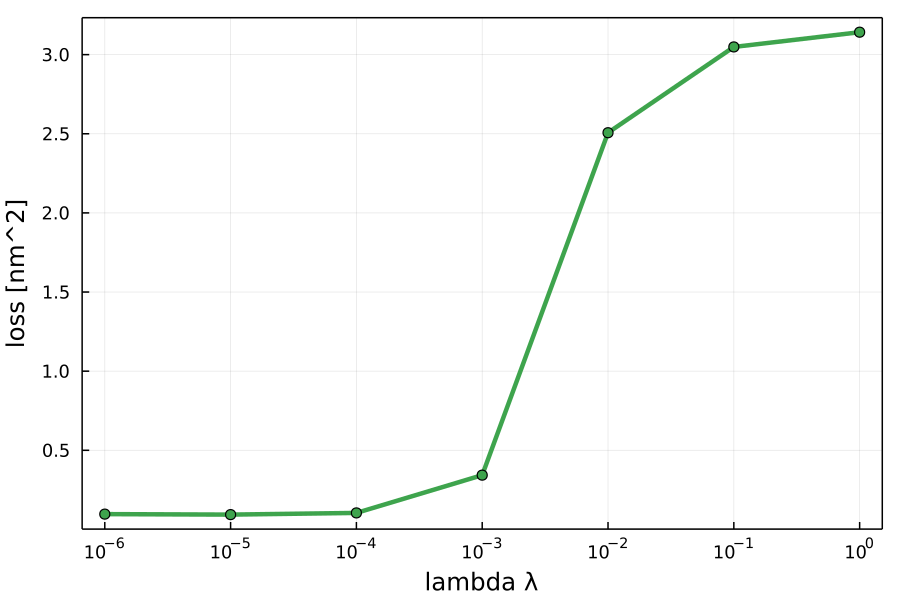

In [218]:
p = plot(lambdas[1:7], loss_over_lambdas / 100.0, xaxis=:log, framestyle = :box, xlabel="lambda λ", ylabel="loss [nm^2]", fontsize=35, label=nothing, linewidth=3.0, markershape=:circle, dpi=150, fmt=:png, color=3)

In [205]:
savefig(p, "blindtip_opening01.png")

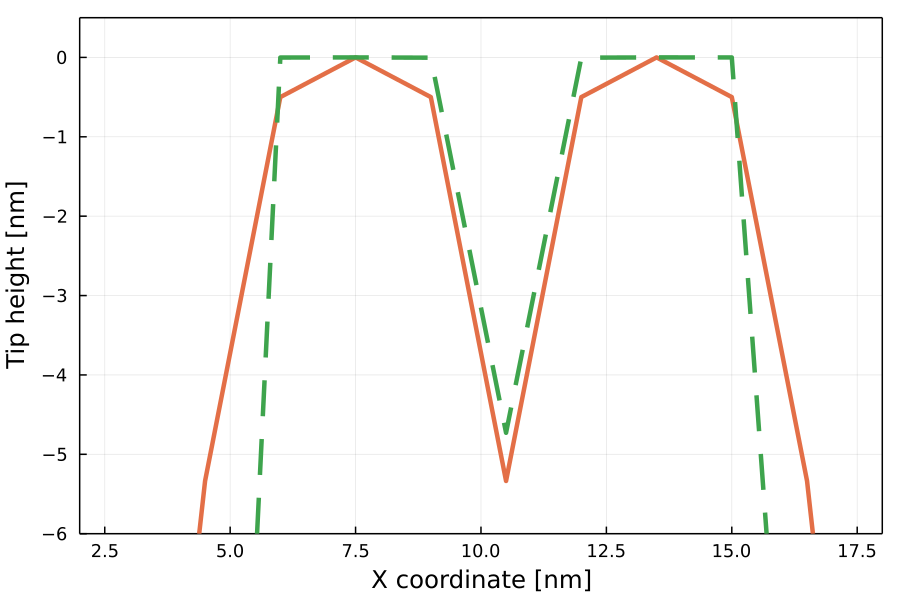

In [220]:
plot(collect(1:nx) .* resolution / 10.0, tip[5, :] / 10.0, linewidth=3, label="ground truth", legend=:bottomright, color=2)
p = plot!((collect(1:nx)) .* resolution / 10.0, MDToolbox.translate_tip_mean(P_over_lambdas[1])[5, :] / 10.0, linewidth=3, linestyle=:dash, label="reconstruction", framestyle=:box, dpi=150, fmt=:png, color=3, legend=nothing)
ylims!((-6, 0.5))
xlims!((2, 18))
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Tip height [nm]", fontsize=35)

In [207]:
savefig(p, "blindtip_opening02.png")

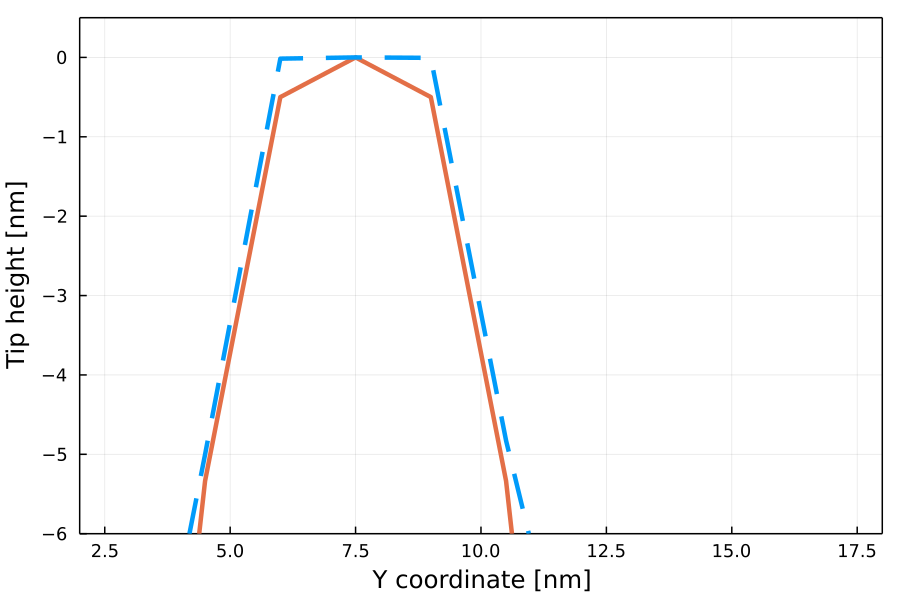

In [222]:
plot(collect(1:ny) .* resolution / 10.0, tip[:, 5] / 10.0, linewidth=3, label="ground truth", color=2)
plot!(collect(1:ny) .* resolution / 10.0, MDToolbox.translate_tip_mean(P_over_lambdas[1])[:, 5] / 10.0, linewidth=3, linestyle=:dash, label="reconstruction", framestyle=:box, dpi=150, fmt=:png, color=1, legend=nothing)
ylims!((-6, 0.5))
xlims!((2, 18))
xlabel!("Y coordinate [nm]", fontsize=35)
ylabel!("Tip height [nm]", fontsize=35)

In [223]:
savefig(p, "blindtip_opening03.png")

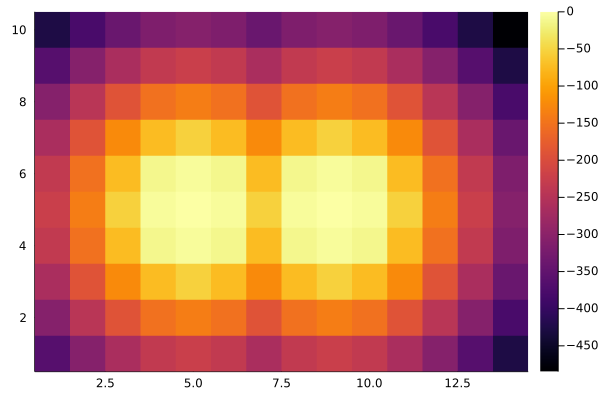

In [224]:
heatmap(tip)

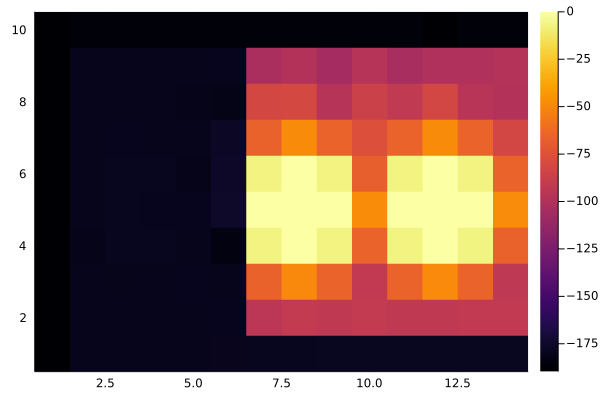

In [225]:
heatmap(P_over_lambdas[3])

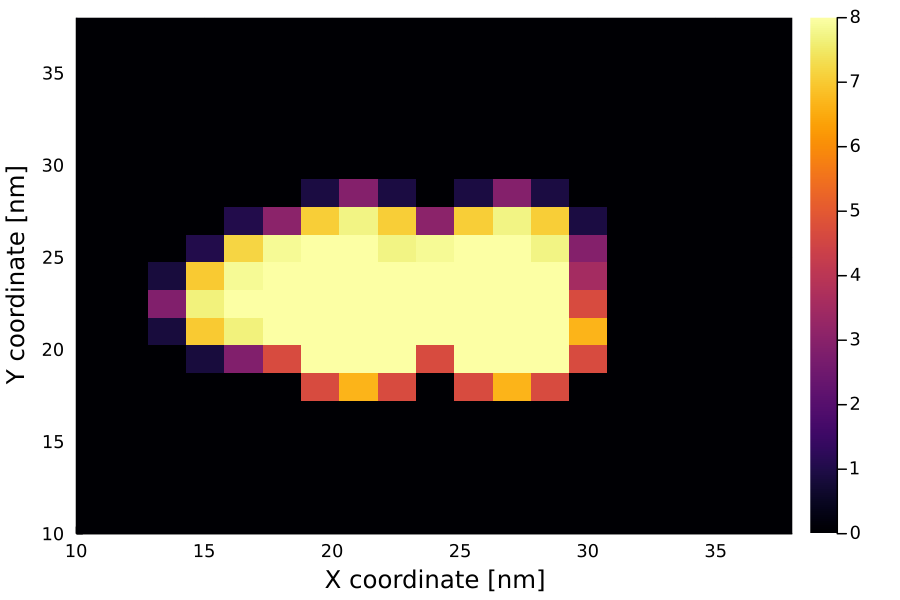

In [226]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, images[1] / 10.0, clim=(0, 8), dpi=150, fmt=:png)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 38)
ylims!(10, 38)

In [227]:
savefig(p, "blindtip_opening04.png")

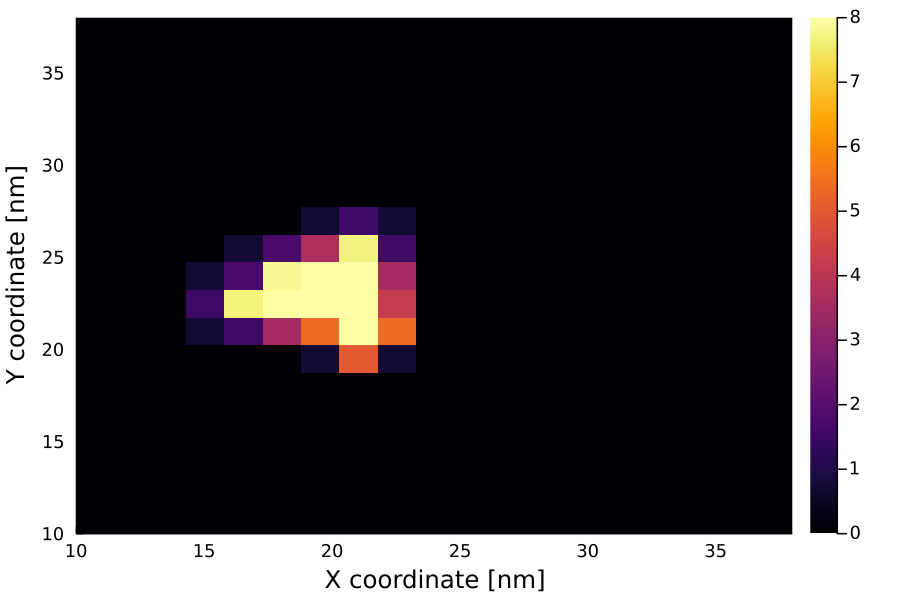

In [228]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, ierosion(images[1], P_over_lambdas[1]) / 10.0, clim=(0, 8), dpi=150, fmt=:png)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 38)
ylims!(10, 38)

In [229]:
savefig(p, "blindtip_opening05.png")

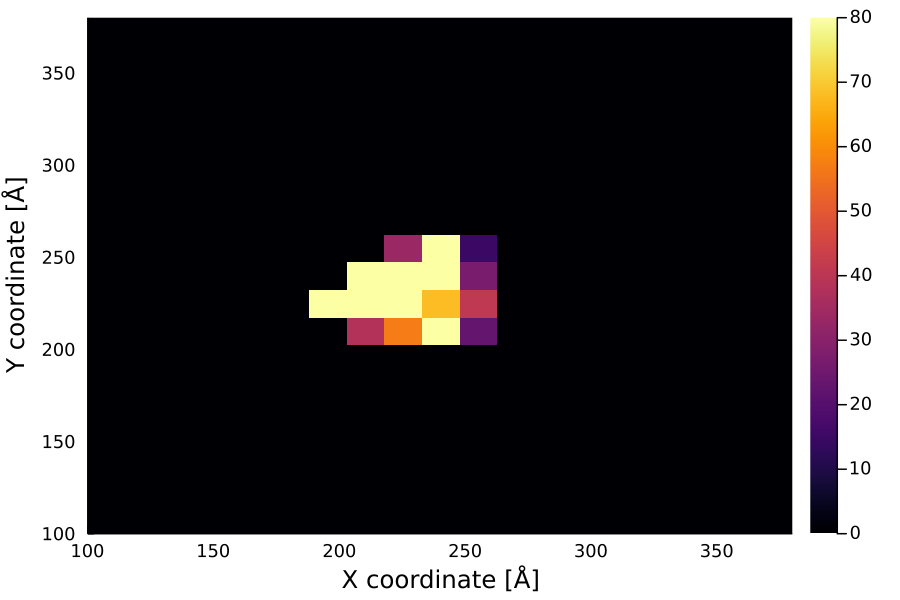

In [230]:
p = heatmap(collect(1:30) .* resolution, collect(1:30) .* resolution, surfs[1], clim=(0, 80), dpi=150, fmt=:png)
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
xlims!(100, 380)
ylims!(100, 380)

In [231]:
savefig(p, "blindtip_opening06.png")